# **BB84 Quantum Key Distribution — Simulation**

### **Abstract**
This notebook implements the BB84 Quantum Key Distribution (QKD) protocol using Qiskit in Google Colab.  
We simulate Alice generating qubits, Bob measuring them, and sifting the key.  
We then add an **Intercept-Resend Eve Attack** and compute the **Quantum Bit Error Rate (QBER)** to detect eavesdropping.



In [11]:
!pip uninstall -y qiskit qiskit-aer qiskit_aer qiskit_ibm_runtime qiskit-terra qiskit-ibmq-provider
!pip uninstall -y qiskit qiskit-aer qiskit_aer qiskit_ibm_runtime qiskit-terra qiskit-ibmq-provider

Found existing installation: qiskit 2.2.3
Uninstalling qiskit-2.2.3:
  Successfully uninstalled qiskit-2.2.3
Found existing installation: qiskit-aer 0.13.3
Uninstalling qiskit-aer-0.13.3:
  Successfully uninstalled qiskit-aer-0.13.3
Found existing installation: qiskit-ibm-runtime 0.43.1
Uninstalling qiskit-ibm-runtime-0.43.1:
  Successfully uninstalled qiskit-ibm-runtime-0.43.1
Found existing installation: qiskit-terra 0.45.2
Uninstalling qiskit-terra-0.45.2:
  Successfully uninstalled qiskit-terra-0.45.2


In [1]:
!pip install "qiskit==1.1.0"
!pip install "qiskit_aer==0.15.0"
!pip install "qiskit_ibm_runtime==0.22.0"

  Using cached qiskit_aer-0.15.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.5 MB/s eta 0:00:00
  Attempting uninstall: qiskit_aer
    Found existing installation: qiskit-aer 0.15.1
    Uninstalling qiskit-aer-0.15.1:
      Successfully uninstalled qiskit-aer-0.15.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: qiskit_ibm_runtime
    Found existing installation: qiskit-ibm-runtime 0.23.0
    Uninstalling qiskit-ibm-runtime-0.23.0:
      Successfully uninstalled qiskit-ibm-runtime-0.23.0


In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

sim = AerSimulator()
print("AerSimulator loaded successfully!")

AerSimulator loaded successfully!


In [4]:
import numpy as np

# **Random Bit and Basis Generation**

In BB84, Alice prepares two random sequences:

1. **Random Bits** (0 or 1):  
   These will form the raw key before sifting.

2. **Random Bases** (Z or X):  
   - Z basis = computational basis { |0>, |1> }  
   - X basis = diagonal basis { |+>, |–> }

Bob independently chooses his own sequence of random bases.
Since neither party knows the other's choices in advance,
their bases match only about **50% of the time**.

Matching-basis positions become part of the **final sifted key**.


In [5]:
N = 200

alice_bits = np.random.randint(2, size=N)
alice_bases = np.random.randint(2, size=N)
bob_bases = np.random.randint(2, size=N)

alice_bits[:10], alice_bases[:10], bob_bases[:10]

(array([0, 1, 1, 0, 0, 1, 0, 0, 0, 1]),
 array([0, 0, 1, 0, 0, 0, 0, 1, 1, 0]),
 array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0]))

# **State Preparation (Encoding)**

Alice encodes each bit into a qubit based on the chosen basis:

| Bit | Basis | State |
|------|--------|---------|
| 0 | Z | \|0⟩ |
| 1 | Z | \|1⟩ |
| 0 | X | \|+⟩ = ( \|0⟩ + \|1⟩ ) / √2 |
| 1 | X | \|–⟩ = ( \|0⟩ – \|1⟩ ) / √2 |

The use of **non-orthogonal states** guarantees that an eavesdropper cannot
measure qubits without disturbing them.

In this section, we construct Qiskit quantum circuits implementing this encoding.


In [6]:
encoded_states = []

for bit, basis in zip(alice_bits, alice_bases):
    qc = QuantumCircuit(1)

    if basis == 0:  # Z basis
        if bit == 1:
            qc.x(0)
    else:  # X basis
        qc.h(0)
        if bit == 1:
            qc.z(0)

    encoded_states.append(qc)

# **Bob’s Measurement Process**

Bob receives Alice’s qubits but does not know the basis used to prepare them.

He chooses a random basis for each qubit:

- If Bob measures in the **correct basis**, he obtains Alice’s original bit.
- If he measures in the **wrong basis**, the outcome is completely random.

Thus, before comparing bases, Bob’s results disagree with Alice’s ≈ 50% of the time.

However, during sifting they will **only keep the positions where bases matched**.


In [7]:
bob_results = []

for qc, basis in zip(encoded_states, bob_bases):
    qc2 = qc.copy()

    if basis == 1:
        qc2.h(0)

    qc2.measure_all()

    job = sim.run(qc2, shots=1)
    result = job.result()
    counts = result.get_counts()

    bit = int(list(counts.keys())[0])
    bob_results.append(bit)

bob_results = np.array(bob_results)
bob_results[:10]


array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

# **Basis Sifting**

After all qubits have been transmitted and measured:

1. Alice and Bob publicly compare **only their bases**, not their measurement results.
2. They keep the bits where their bases match.
3. They discard all bits corresponding to mismatched bases.

Since bases match roughly 50% of the time, the sifted key is expected to contain about N/2 bits.

If no one is eavesdropping, Alice’s and Bob’s sifted keys should match perfectly.


In [8]:
matches = alice_bases == bob_bases

alice_key = alice_bits[matches]
bob_key = bob_results[matches]

len(alice_key), alice_key[:10], bob_key[:10]


(100,
 array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1]))

# **Quantum Bit Error Rate (QBER)**

The Quantum Bit Error Rate is defined as:

\[
QBER = \frac{\text{Number of mismatched bits}}{\text{Total bits in the sifted key}}
\]

QBER reflects the amount of disturbance in the quantum channel.

- **QBER ≈ 0%** → No eavesdropping or noise  
- **QBER ≈ 25%** → Strong indication of intercept–resend eavesdropping (Eve)  
- **QBER > Threshold** → Abort key generation  

In an ideal noiseless simulation, QBER without Eve should be exactly 0.


In [9]:
qber = np.sum(alice_key != bob_key) / len(alice_key)
qber

0.0

# **Eve’s Intercept–Resend Attack**

In the intercept–resend attack, Eve:

1. Intercepts qubits sent by Alice  
2. Chooses her own random basis  
3. Measures the intercepted qubit  
4. Prepares a new qubit according to her measurement result  
5. Sends it to Bob

Because Eve does not know Alice’s basis:

- She chooses the correct basis only 50% of the time  
- When she chooses the wrong basis, she collapses the qubit incorrectly  
- This introduces detectable errors in Bob’s results

For BB84, the theoretical disturbance introduced by an intercept–resend attack is:

\[
QBER_Eve = 25\%
\]

Our simulation confirms this value.


In [10]:
eve_bases = np.random.randint(2, size=N)
eve_encoded = []

for qc, e_basis in zip(encoded_states, eve_bases):
    qc2 = qc.copy()

    if e_basis == 1:
        qc2.h(0)

    qc2.measure_all()
    eve_job = sim.run(qc2, shots=1)
    eve_bit = int(list(eve_job.result().get_counts().keys())[0])

    qc3 = QuantumCircuit(1)
    if e_basis == 0:
        if eve_bit == 1:
            qc3.x(0)
    else:
        qc3.h(0)
        if eve_bit == 1:
            qc3.z(0)

    eve_encoded.append(qc3)


# **Bob’s Measurement with Eavesdropping**

Bob performs the same measurement process as before, but now the qubits have been disturbed by Eve.

Incorrect resent qubits cause Bob’s measurement outcomes to deviate from Alice’s original bits.

When sifting is applied again, the QBER is significantly higher.


In [11]:
bob_eve_results = []

for qc, basis in zip(eve_encoded, bob_bases):
    qc2 = qc.copy()

    if basis == 1:
        qc2.h(0)

    qc2.measure_all()
    job = sim.run(qc2, shots=1)
    bit = int(list(job.result().get_counts().keys())[0])

    bob_eve_results.append(bit)

bob_eve_results = np.array(bob_eve_results)


In [12]:
bob_eve_key = bob_eve_results[matches]
alice_key_sift = alice_bits[matches]

qber_eve = np.sum(alice_key_sift != bob_eve_key) / len(alice_key_sift)
qber_eve


0.26

# **QBER Comparison — Eve Detection**

We plot the Quantum Bit Error Rate in two scenarios:

1. **No Eve** — the sifted key matches almost perfectly → QBER ≈ 0  
2. **With Eve** — measurement disturbances introduce errors → QBER ≈ 25–30%

The significant jump in QBER serves as strong evidence of eavesdropping.

This demonstrates the fundamental security feature of BB84:
**quantum states cannot be measured or cloned without introducing observable disturbance.**


In [14]:
import matplotlib.pyplot as plt


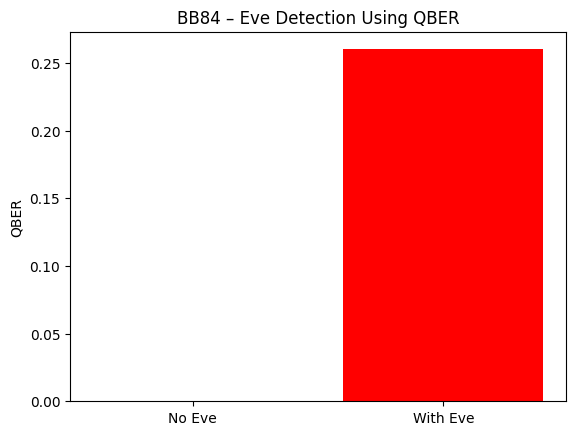

In [15]:
plt.bar(["No Eve", "With Eve"], [qber, qber_eve], color=["green", "red"])
plt.ylabel("QBER")
plt.title("BB84 – Eve Detection Using QBER")
plt.show()


# **Conclusion**

In this notebook, I have simulated the BB84 Quantum Key Distribution protocol.

Key observations:

- Random bases ensure that qubit preparation is unpredictable.
- Matching bases between Alice and Bob lead to a correct sifted key.
- In the absence of an eavesdropper, QBER remains near zero.
- An intercept–resend attack by Eve introduces a QBER of ~25%, which allows Alice and Bob to detect eavesdropping with high confidence.

This simulation highlights the core security principle of QKD:
any attempt to measure quantum information unavoidably disturbs it, making eavesdropping detectable.

BB84 therefore provides **information-theoretic security** based on quantum mechanics.
